In [5]:
import logging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import time
from pathlib import Path

import soundfile as sf
import torch
import yaml
import numpy as np
from prosody.utils import *
from prosody.pinyin import *
from espnet2.text.phoneme_tokenizer import PhonemeTokenizer
from espnet2.text.token_id_converter import TokenIDConverter
from parallel_wavegan.utils import load_model as load_vocoder
from espnet2.bin.tts_inference import Text2Speech
from matplotlib import pyplot as plt
%load_ext autoreload

PWD = %pwd
PWD = Path(PWD)
LJSPEECH_DIR = (PWD / '../egs2/ljspeech/tts1/').resolve()
VCTK_DIR = (PWD / '../egs2/vctk/tts1/').resolve()
device = 'cuda'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
%aimport prosody.utils.utils
%autoreload prosody.utils.utils
from prosody.utils import *

In [6]:
cwd = os.getcwd()
os.chdir(LJSPEECH_DIR)
pretrained_dir = LJSPEECH_DIR / "exp/tts_train_jets_raw_phn_tacotron_g2p_en_no_space"
pretrained_model_file = pretrained_dir / "train.total_count.ave_5best.pth"
pretrained_tts = Text2Speech.from_pretrained(
    train_config=pretrained_dir / "config.yaml",
    model_file=pretrained_model_file,
    device=device
)
pretrained_model = pretrained_tts.model
os.chdir(cwd)

In [208]:
orig_text = 'This is a very long text, which i expect the model to read properly and not too fast.'

In [209]:
arpa_tokenizer = PhonemeTokenizer(g2p_type='g2p_en')
arpa_phones = arpa_tokenizer.g2p(orig_text)

In [7]:
arpa_tokenizer = PhonemeTokenizer(g2p_type='g2p_en_no_space')
id_converter = TokenIDConverter(pretrained_tts.train_args.token_list)

In [211]:
arpa_phones = [p for p in arpa_phones if p != ' ']
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [212]:
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [213]:
orig_text = 'shaw, those twelve beige hooks are joined if i patch a young, gooey mouth.'

In [214]:
orig_text = "THIS, *is* ^AB^soLUTE_ly craaaaazzzyyyyy!!"

In [215]:
orig_text = "Is thaaaaaaaat correct?"

In [216]:
orig_text = "booooook"

In [217]:
phonemes, phone_ids, d_factor, p_factor, e_factor = get_inputs(orig_text, tokens2ids_fn=id_converter.tokens2ids)

ValueError: too many values to unpack (expected 5)

In [ ]:
long_wav_file = '/home/perry/PycharmProjects/LJSpeech-1.1/wavs/LJ035-0185.wav'
short_wav_file = '/home/perry/PycharmProjects/LJSpeech-1.1/wavs/LJ050-0162.wav'
long_text = 'After inspecting this floor, Sawyer returned to the street about three minutes after he entered the building.'
custom_text = 'This is a longer sentence which we want to change the style for.'

custom_text = "I thought you meant how old are you!"
short_text = 'In planning its data processing techniques,'

In [ ]:
amused_short_file = '/home/perry/PycharmProjects/EmoV_DB/bea_Amused/amused_196-224_0205.wav'
ref_filename = Path(amused_short_file).stem

In [ ]:
amused_short_file = '/home/perry/PycharmProjects/EmoV_DB/bea_Amused/amused_225-252_0247.wav'
ref_filename = Path(amused_short_file).stem

In [ ]:
angry_short_file = '/home/perry/PycharmProjects/EmoV_DB/bea_Angry/anger_225-252_0240.wav'
ref_filename = Path(angry_short_file).stem

In [ ]:
surprise_short_file = '/home/perry/PycharmProjects/ESD/0018/Surprise/test/0018_001423.wav'
ref_filename = Path(surprise_short_file).stem

In [ ]:
arpa_phones = arpa_tokenizer.text2tokens(custom_text)
phone_ids = torch.tensor(id_converter.tokens2ids(arpa_phones), device=device)

In [ ]:
pretrained_model.pitch_extract.f0max = 800

In [ ]:
from glob import glob
wav_paths = glob('/home/perry/PycharmProjects/LJSpeech-1.1/wavs/*.wav')
pitch_range, energy_range = find_dataset_ranges(wav_paths, pretrained_tts)

In [ ]:
pitch_range = (-4.52626895904541, 3.51578950881958)

In [ ]:
energy_range = (-1.1005744934082031, 14.794838905334473)

In [ ]:
plt.plot([256/44100*i for i in range(pitch.shape[1])], pitch.squeeze().cpu())
# plt.plot(speech.squeeze().cpu())

In [ ]:
energy, energy_lengths = pretrained_model.energy_extract(speech, speech_lengths, feats_lengths=feats_lengths)
energy = pretrained_model.energy_normalize(energy.squeeze(-1), energy_lengths)[0].unsqueeze(-1)
plt.plot(energy.squeeze().cpu())

In [ ]:
long_surprise_texts = [
    'Why do all your coffee mugs have numbers on the bottom?',
    'Okay, so you were trying to play bad this whole time.',
    "Rach, I'm sorry, but you didn't give me any contracts!"
]
short_surprise_texts = [
    "They're not listening to me?",
    'Wow, you guys, this is big.',
    "It's nine o'clock in the morning!",
]
long_sad_texts = [
    "Oh come on, what am I gonna do, its been hours and it won't stop crying.",
    'I guess I just figured that somewhere down the road, we would be on again.',
    'No, I had to return it to the costume place.'
]
short_sad_texts = [
    'Can we please turn this off?',
    "I mean, no, you're right.",
    "Well it's very unsettling."
]

In [ ]:
short_surprise_ref = [
    '/home/perry/PycharmProjects/ESD/0016/Surprise/test/0016_001449.wav',
    '/home/perry/PycharmProjects/ESD/0017/Surprise/test/0017_001423.wav',
    '/home/perry/PycharmProjects/ESD/0018/Surprise/test/0018_001421.wav',

]
long_surprise_ref = [
    '/home/perry/PycharmProjects/ESD/0016/Surprise/test/0016_001450.wav',
    '/home/perry/PycharmProjects/ESD/0017/Surprise/test/0017_001428.wav',
    '/home/perry/PycharmProjects/ESD/0018/Surprise/test/0018_001440.wav'
]
short_sad_ref = [
    '/home/perry/PycharmProjects/ESD/0016/Sad/test/0016_001091.wav',
    '/home/perry/PycharmProjects/ESD/0017/Sad/test/0017_001086.wav',
    '/home/perry/PycharmProjects/ESD/0018/Sad/test/0018_001092.wav',
]
long_sad_ref = [
    '/home/perry/PycharmProjects/ESD/0016/Sad/test/0016_001090.wav',
    '/home/perry/PycharmProjects/ESD/0017/Sad/test/0017_001078.wav',
    '/home/perry/PycharmProjects/ESD/0018/Sad/test/0018_001084.wav'
]

In [ ]:
extracted_feats = extract_normalized_feats(surprise_short_file, pretrained_tts)
speech, speech_lengths, feats, feats_lengths, pitch, pitch_lengths, energy, energy_lengths = extracted_feats

In [ ]:
def threshold(raw_val):
    return pretrained_model.energy_normalize(torch.tensor([[raw_val]]), torch.tensor([1]))[0].squeeze().item()

In [ ]:
is_vowels = torch.tensor([p in ARPA_VOWELS for p in arpa_phones], device=device)
is_consonants = torch.tensor([p not in ARPA_VOWELS and p not in PUNCS for p in arpa_phones], device=device)

In [ ]:
pitch.shape

In [ ]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem

In [ ]:
with torch.no_grad():
    output_dict = pretrained_model.tts.generator.inference(
        text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
        verbose=True,
    )
sf.write(save_dir / 'transfer' / f'{custom_text}.wav',
         output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

In [ ]:
questions = ['What are you working on?']
gts = ['/home/perry/PycharmProjects/dailytalk/data/0/0_1_d0.wav']

In [ ]:
questions = ["Did you bring some lunch with you?"]
gts = ['/home/perry/PycharmProjects/dailytalk/data/3/0_1_d3.wav']

In [ ]:
from shutil import copyfile
save_dir = Path('/home/perry/firebase3/public/questions/')

In [ ]:
orig_feats = extract_normalized_feats(save_dir / 'transfer' / f'{custom_text}.wav', pretrained_tts=pretrained_tts)

In [ ]:

for question, gt in zip(questions, gts):
    with torch.no_grad():
        fname = re.sub(r'[^A-Za-z ]', '', question).replace(' ', '_')
        arpa_phones = arpa_tokenizer.text2tokens(question)
        phonemes, phone_ids, d_factor, p_factor, e_factor, d_split_factor = get_inputs(question, tokens2ids_fn=id_converter.tokens2ids)
        wav, _, _ = pretrained_model.tts.generator.inference(
            text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
            verbose=True,
        )
        sf.write(save_dir / 'jets' /  f'{fname}.wav', wav.squeeze().cpu().numpy(), 22050, "PCM_16")
        wav_modified, _, _ = pretrained_model.tts.generator.inference(
            text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
            p_factor=p_factor,
            verbose=True,
        )
        sf.write(save_dir / 'present' /  f'{fname}.wav', wav_modified.squeeze().cpu().numpy(), 22050, "PCM_16")
        copyfile(gt, save_dir / 'dailytalk' /  f'{fname}.wav')

In [46]:
from espnet2.gan_tts.jets.generator import *

In [88]:
e_reference = energy.squeeze(-1)
p_reference = pitch.squeeze(-1)
avg_energy = compute_avg_energy(e_reference, duration_pred, window=9)
e_threshold = threshold(10.0)

In [27]:
is_vowels.sum()

tensor(15, device='cuda:0')

In [56]:
avg_energy = compute_avg_energy(e_reference, duration_pred, window=8)
energy = avg_energy.clone()
keep_frames = energy > e_threshold
energy = energy[keep_frames]
pitch = p_reference.squeeze()[keep_frames]
peaks = find_peaks(energy)

In [58]:
len(peaks)

10

In [15]:
energy = avg_energy.clone()
keep_frames = energy > threshold(10.0)
energy = energy[keep_frames]
peaks = find_peaks(energy)
num_peaks = len(peaks)
num_vowels = sum(is_vowels).item()

In [40]:
repeats = compute_repeats(num_vowels, num_peaks)
peaks_new, pitch_new, energy_new = repeat_peaks_(repeats, peaks, num_peaks, pitch, energy)

152
246


In [29]:
len(energy)

197

In [44]:
find_peaks(energy_new)

tensor([  6,  37,  56,  78,  90, 116, 121, 145, 165, 170, 194, 206, 212, 238,
        243], device='cuda:0')

In [43]:
peaks_new

tensor([  6,  37,  56,  78,  90, 116, 121, 145, 165, 170, 194, 206, 212, 238,
        243], device='cuda:0')

In [38]:
peaks[-7:]

tensor([116, 121, 145, 157, 163, 189, 194], device='cuda:0')

In [25]:
peaks = find_peaks(energy)

In [32]:
peaks

tensor([ 5, 17, 36, 52, 69, 74, 80, 97], device='cuda:0')

In [33]:
energy_mask = avg_energy > threshold(10.0)
start = 0
while not energy_mask[start]:
    start += 1
end = -1
while not energy_mask[end]:
    end -= 1
ref_actual_len = len(avg_energy) - start + end + 1

In [34]:
ref_actual_len / len(peaks) * 22050/16000

18.6046875

In [32]:
157 / len(peaks)

15.7

In [24]:
(peaks[-1] - peaks[0]) / (len(peaks)-1)

tensor(14.6667, device='cuda:0')

In [28]:
energy_mask = avg_energy > threshold(0.0)
ref_frames = len(energy_mask)
start = 0
while not energy_mask[start]:
    start += 1
end = -1
while not energy_mask[end]:
    end -= 1

In [46]:
len(avg_energy)

157

In [29]:
actual_len = len(avg_energy) - start + end + 1

In [30]:
actual_len

157

In [50]:
sum(energy_mask)

tensor(130, device='cuda:0')

In [31]:
duration_pred.sum() / sum(is_vowels)

tensor(22.4667, device='cuda:0')

In [29]:
out_feats = extract_normalized_feats(out_path)

In [41]:
gener_feats = extract_normalized_feats(f'/home/perry/PycharmProjects/GenerSpeech/infer_out/{custom_text}-ref{ref_filename}.wav')

In [35]:
from espnet2.gan_tts.jets.alignments import average_by_duration
p_outs = average_by_duration(
                duration_pred.unsqueeze(0), orig_pitch.unsqueeze(0), torch.tensor([len(phone_ids)], device=device), orig_feats[3]
            ).unsqueeze(-1)

In [179]:
pitch.shape

torch.Size([94])

In [15]:
def normalize_to_pred(reference, pred):
    min_pred = pred.min()
    scale = (pred.max() - min_pred) / (reference.max() - reference.min())
    scaled_ref = reference * scale
    reference = scaled_ref - scaled_ref.min() + min_pred
    return reference

In [16]:
avg_energy = normalize_to_pred(avg_energy, energy_pred)
pitch = normalize_to_pred(pitch, pitch_pred)

In [19]:
num_vowels = is_vowels.sum().item()

In [17]:
def shift_pad(x, shift, pad=0):
    y = x.roll(shift)
    if shift < 0:
        y[shift:] = pad
    else:
        y[0:shift] = pad
    return y

In [21]:
avg_energy_left = shift_pad(avg_energy, -1)
avg_energy_right = shift_pad(avg_energy, 1)

In [22]:
peaks = torch.nonzero((avg_energy > avg_energy_left) & (avg_energy > avg_energy_right)).squeeze()

In [23]:
num_peaks = len(peaks)

In [24]:
if num_peaks < num_vowels:
    scale = math.ceil(num_vowels / num_peaks)
    peaks = torch.flatten(peaks + torch.arange(scale, device=device).unsqueeze(1) * len(avg_energy))
    avg_energy = avg_energy.repeat(scale)
    pitch = pitch.repeat(scale)

In [25]:
energy_new = energy_pred.clone()

In [26]:
energy_new[is_vowels] = avg_energy[peaks]

In [27]:
pitch_new = pitch_pred.clone()
pitch_new[is_vowels] = pitch[peaks]

In [28]:
vowel_indices = torch.nonzero(is_vowels).squeeze()

In [29]:
duration_start = shift_pad(duration_pred.cumsum(0), shift=1)

In [30]:
phone_positions = duration_start + duration_pred / 2

In [31]:
def add_start_end(x, start_value, end_value):
    y = torch.zeros(len(x)+2, dtype=x.dtype, device=x.device)
    y[0] = start_value
    y[1:-1] = x
    y[-1] = end_value
    return y

In [32]:
phone_positions = add_start_end(phone_positions, 0, duration_pred.sum())

In [33]:
vowel_positions = add_start_end(phone_positions[1:-1][is_vowels], 0, phone_positions[-1])

In [34]:
vowel_indices = torch.nonzero(is_vowels).squeeze()
vowel_indices = add_start_end(vowel_indices, -1, len(duration_pred))

In [35]:
vowel_indices

tensor([-1,  1,  3,  5,  7, 10, 12, 15, 19, 22, 24, 28, 30, 34, 37, 40, 43],
       device='cuda:0')

In [36]:
phone_positions = add_start_end(phone_positions, 0, duration_pred.sum())

In [37]:
peaks = add_start_end(peaks, 0, len(avg_energy))

In [41]:
pitch_pred.squeeze()

tensor([ 1.0081,  1.6838,  1.6185,  1.3124,  1.0328,  0.6366,  0.4254,  0.5206,
         0.3145, -0.0381, -0.2157,  0.0195, -0.3340, -0.4843, -0.3955, -0.4867,
        -0.2431, -0.3562, -0.3014, -0.1122,  0.0362,  0.0138, -0.3176, -0.2748,
        -0.1264,  0.0293,  0.0540,  0.2609,  0.2613,  0.3070, -0.4706, -0.5565,
        -0.3059,  0.0631,  0.0668,  0.2042, -0.1482, -0.6567, -0.6116,  0.2347,
        -0.1922, -0.7975, -0.7153], device='cuda:0')

In [40]:
pitch_new

tensor([ 1.0081, -0.4784,  1.6185,  1.4350,  1.0328,  1.4863,  0.4254,  1.1621,
         0.3145, -0.0381,  1.1934,  0.0195, -0.4784, -0.4843, -0.3955,  1.4350,
        -0.2431, -0.3562, -0.3014,  1.4863,  0.0362,  0.0138,  1.1621, -0.2748,
         1.1934,  0.0293,  0.0540,  0.2609, -0.4784,  0.3070,  1.4350, -0.5565,
        -0.3059,  0.0631,  1.4863,  0.2042, -0.1482,  1.1621, -0.6116,  0.2347,
         1.1934, -0.7975, -0.7153], device='cuda:0')

In [42]:
for start_vowel, end_vowel, start_peak, end_peak in zip(vowel_indices[:-1], vowel_indices[1:], peaks[:-1], peaks[1:]):
    start_peak = start_peak.item()
    end_peak = end_peak.item()
    peak_interval = end_peak - start_peak
    print('\n', start_vowel.item(), 'to', end_vowel.item(), 'peak:', start_peak, end_peak)
    start_position = 0 if start_vowel == -1 else phone_positions[start_vowel+1].item()
    end_position = phone_positions[end_vowel+1].item()
    print(start_position, end_position)
    interval = end_position - start_position
    for phone_i in range(start_vowel, end_vowel):  # phone index
        if is_consonants[phone_i]:
            consonant_position = phone_positions[phone_i+1].item()
            print(arpa_phones[phone_i], phone_i, consonant_position)
            consonant_frame = start_peak + (consonant_position - start_position) / interval * peak_interval
            print(consonant_frame)
            floor_frame = int(consonant_frame)
            consonant_pitch = pitch[floor_frame] * (floor_frame + 1 - consonant_frame) + pitch[floor_frame+1] * (consonant_frame - floor_frame)
            consonant_energy = avg_energy[floor_frame] * (floor_frame + 1 - consonant_frame) + avg_energy[floor_frame+1] * (consonant_frame - floor_frame)
            print('new_pitch', consonant_energy, 'new energy', consonant_pitch)
            pitch_new[phone_i] = consonant_pitch
            energy_new[phone_i] = consonant_energy


 -1 to 1 peak: 0 15
0 3.5
DH 0 0.0
0.0
new_pitch tensor(-1.0561, device='cuda:0') new energy tensor(-0.4784, device='cuda:0')

 1 to 3 peak: 15 25
3.5 19.5
S 2 10.5
19.375
new_pitch tensor(0.6186, device='cuda:0') new energy tensor(0.7676, device='cuda:0')

 3 to 5 peak: 25 39
19.5 35.0
Z 4 28.5
33.12903225806451
new_pitch tensor(0.3974, device='cuda:0') new energy tensor(1.4417, device='cuda:0')

 5 to 7 peak: 39 63
35.0 49.5
L 6 42.0
50.58620689655172
new_pitch tensor(-0.3061, device='cuda:0') new energy tensor(1.2194, device='cuda:0')

 7 to 10 peak: 63 80
49.5 67.0
NG 8 56.5
69.8
new_pitch tensor(-0.7593, device='cuda:0') new energy tensor(1.4110, device='cuda:0')
G 9 62.0
75.14285714285714
new_pitch tensor(-0.4180, device='cuda:0') new energy tensor(1.1598, device='cuda:0')

 10 to 12 peak: 80 109
67.0 82.0
S 11 74.0
93.53333333333333
new_pitch tensor(-1.0643, device='cuda:0') new energy tensor(0.1268, device='cuda:0')

 12 to 15 peak: 109 119
82.0 102.0
N 13 89.0
112.5
new_pitch

In [43]:
pitch_new

tensor([-0.4784, -0.4784,  0.7676,  1.4350,  1.4417,  1.4863,  1.2194,  1.1621,
         1.4110,  1.1598,  1.1934,  0.1268, -0.4784,  0.4782,  1.3632,  1.4350,
         1.5043,  1.4709,  1.6010,  1.4863,  1.3297,  1.1771,  1.1621,  1.4057,
         1.1934,  0.9932, -0.4784, -0.4784, -0.4784,  0.7527,  1.4350,  1.4600,
         1.4405,  1.6672,  1.4863,  1.3048,  1.1730,  1.1621,  1.3809,  1.3098,
         1.1934,  1.0479, -0.7153], device='cuda:0')

In [51]:
with torch.no_grad():
    output_dict = pretrained_model.tts.generator.inference(
        text=phone_ids.unsqueeze(0), text_lengths=torch.tensor([len(phone_ids)], device=device),
        p_reference=pitch_new.unsqueeze(-1)[None], e_reference=energy_new.unsqueeze(-1)[None],
        verbose=True,
    )

Duration pred: tensor([ 7,  7, 11,  7,  6,  8,  7,  7,  4,  6,  8,  8,  6,  7,  6,  6,  7,  7,
         7,  6,  7,  7, 12,  9,  7,  7,  3,  6, 10, 11, 11,  7,  6,  8,  7,  7,
         9, 11,  9, 14, 13,  9,  9], device='cuda:0')
Pitch pred: tensor([ 1.0081,  1.6838,  1.6185,  1.3124,  1.0328,  0.6366,  0.4254,  0.5206,
         0.3145, -0.0381, -0.2157,  0.0195, -0.3340, -0.4843, -0.3955, -0.4867,
        -0.2431, -0.3562, -0.3014, -0.1122,  0.0362,  0.0138, -0.3176, -0.2748,
        -0.1264,  0.0293,  0.0540,  0.2609,  0.2613,  0.3070, -0.4706, -0.5565,
        -0.3059,  0.0631,  0.0668,  0.2042, -0.1482, -0.6567, -0.6116,  0.2347,
        -0.1922, -0.7975, -0.7153], device='cuda:0')
Energy pred: tensor([ 0.2849,  1.4135,  0.9846,  0.2767,  0.4766,  0.5926,  1.2596,  1.1123,
        -0.0578,  0.3281, -0.1041,  0.3554,  0.5286, -0.6662, -0.3353, -0.2382,
        -0.3709, -0.3895, -0.6102, -0.3633, -0.6187,  0.1462,  0.1574,  0.1421,
         0.4741, -0.6809, -0.9164, -0.4543, -0.6819, 

In [52]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
sf.write(save_dir / 'transfer' / f'This is a longer sentence which we want to change the style for.-ref0018_000742.wav', output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

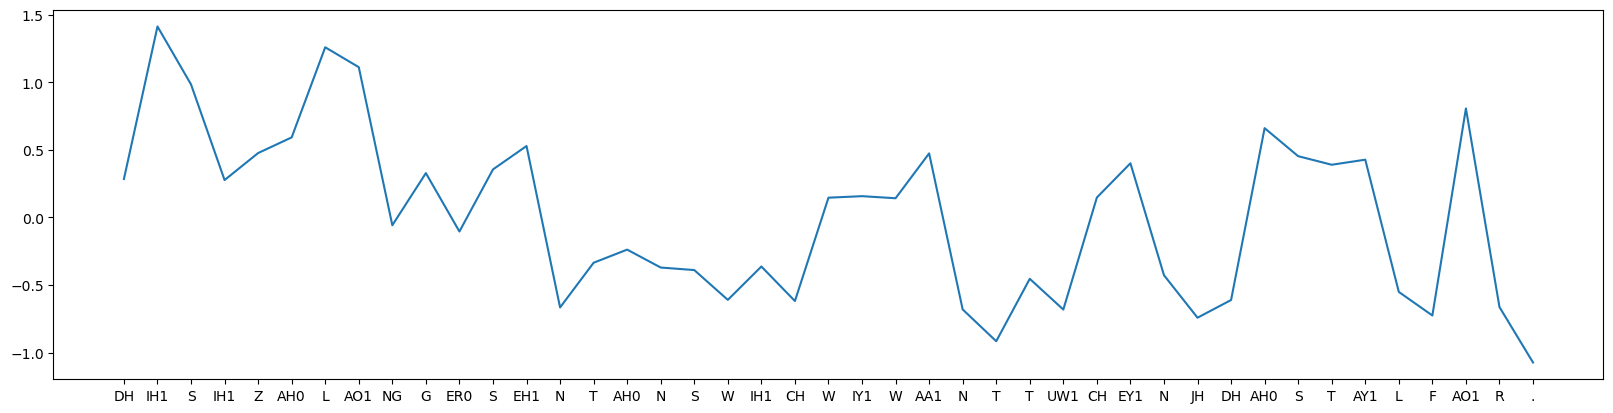

In [28]:
plt.figure().set_figwidth(20)
plt.xticks(range(len(arpa_phones)), arpa_phones)
plt.plot(energy_pred)

In [26]:
len(energy_pred)

43

In [30]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
sf.write(save_dir / 'transfer' / f'long_text_from_short.wav', output_dict[0].squeeze().cpu().numpy(), 22050, "PCM_16")

In [9]:
feats_dict = pretrained_model.collect_feats(batch)

TypeError: collect_feats() missing 3 required positional arguments: 'text_lengths', 'speech', and 'speech_lengths'

In [27]:
vowel_count = sum(phoneme in vowels for phoneme in phonemes)
batch_phone_ids = [phone_ids] * (1+vowel_count)
batch_d_factor = d_factor.unsqueeze(0).repeat(1+vowel_count, 1, 1)
batch_text = [orig_text] * (1+vowel_count)
count = 1
for i, phoneme in enumerate(phonemes):
    if phoneme in vowels:
        batch_text[count] = batch_text[count] + f'{count}{phoneme}x3'
        batch_d_factor[count][0, i] = 4.0
        count += 1

In [7]:
with torch.no_grad():
    output_dict = pretrained_model.tts.inference(text=phone_ids)
outputs, batch_text = [output_dict], [orig_text]

In [8]:
wav = output_dict['wav'].detach().cpu().numpy()

In [13]:
duration = output_dict['duration']

In [11]:
vowel_positions = [i for i, phone in enumerate(phonemes) if phone in vowels]

In [4]:
def fill_fn_risefall(h_val, fac, div):
    count = fac.item()
    if count < 3:
        return h_val
    else:
        rising = np.linspace(0, 1, (count+1)//2)
        falling = np.flip(rising)
        # falling = np.zeros(rising.shape)
        if count % 2 == 0:
            fill_arr = np.concatenate([rising, falling])
        else:
            fill_arr = np.concatenate([rising, falling[1:]])
        fill_tensor = torch.tensor(fill_arr, device=h_val.device)
        if h_val.ndim:
            fill_tensor = fill_tensor.unsqueeze(-1)
        return fill_tensor

In [11]:
def fill_fn(h_val, fac, div):
    count = fac.item()
    if count < 2:
        return h_val
    else:
        fill_arr = np.linspace(0.0, 1.0, count)
        fill_tensor = torch.tensor(fill_arr, device=h_val.device)
        if h_val.ndim:
            fill_tensor = fill_tensor.unsqueeze(-1)
        return fill_tensor

In [5]:
# phonemes = ['K', 'R', 'EY1', 'Z', 'IY0']
# phonemes = ['DH', 'AE1', 'T', '.']
phonemes = ['SH', 'UH1', 'R', '.']
# phonemes = ['N', 'OW1', '!', '!']
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
with torch.no_grad():
    # d_factor = torch.tensor([[1.0, 1.0, 6.0, 1.0, 1.0]], device=device)
    d_factor = torch.tensor([[1.0, 5.0, 1.0, 1.0]], device=device)
    d_split_factor = torch.tensor([[1.0, 2.0, 1.0, 1.0]], device=device)
    output_dict = pretrained_model.tts.inference(text=phone_ids,
                                                 d_factor=d_factor,
                                                 d_split_factor=d_split_factor,
                                                 p_fill_fn=fill_fn_risefall,
                                                 e_fill_fn=fill_fn_risefall,
                                                 # p_factor=(d_factor-1)/3.0,
                                                 verbose=True
                                                 )
    wav = output_dict['wav']
    save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
    # sf.write(save_dir / f'that.ax6.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # sf.write(save_dir / f'no!!ox4_8risefall.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # sf.write(save_dir / f'crazy_ax6_rise-0.5fall-0.5.wav', wav.cpu().numpy(), 22050, "PCM_16")
    sf.write(save_dir / f'sure.ux5.10risefall.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # d_factor = torch.tensor([[1.0, 1.0, 4.0, 1.0, 1.0]], device=device)
    # output_dict = pretrained_model.tts.inference(text=phone_ids, d_factor=d_factor, d_interpolate=False)
    # wav = output_dict['wav']
    # save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
    # sf.write(save_dir / f'crazy.ax4.wav', wav.cpu().numpy(), 22050, "PCM_16")

Duration pred: tensor([19.4989, 13.2591, 10.9338,  9.1970], device='cuda:0')
Pitch pred: tensor([ 0.8972,  0.1140, -0.8402, -0.9685], device='cuda:0')
Energy pred: tensor([ 0.1597,  0.8255, -0.3954, -1.0230], device='cuda:0')
Duration (new): tensor([19,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 11,  9], device='cuda:0')
Pitch (new): tensor([ 0.8972,  0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.0000,  0.7500,
         0.5000,  0.2500,  0.0000, -0.8402, -0.9685], device='cuda:0')
Energy (new): tensor([ 0.1597,  0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.0000,  0.7500,
         0.5000,  0.2500,  0.0000, -0.3954, -1.0230], device='cuda:0')


In [7]:
# phonemes = ['K', 'R', 'EY1', 'Z', 'IY0']
# phonemes = ['DH', 'AE1', 'T', '.']
phonemes = ['SH', 'UH1', 'R', '.']
# phonemes = ['N', 'OW1', '!', '!']
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
with torch.no_grad():
    # d_factor = torch.tensor([[1.0, 1.0, 6.0, 1.0, 1.0]], device=device)
    d_factor = torch.tensor([[1.0, 5.0, 1.0, 1.0]], device=device)
    d_split_factor = torch.tensor([[1.0, 2.0, 1.0, 1.0]], device=device)
    output_dict = pretrained_model.tts.inference(text=phone_ids,
                                                 d_factor=d_factor,
                                                 d_split_factor=d_split_factor,
                                                 p_fill_fn=fill_fn_risefall,
                                                 e_fill_fn=fill_fn_risefall,
                                                 # p_factor=(d_factor-1)/3.0,
                                                 verbose=True
                                                 )
    wav = output_dict['wav']
    save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
    # sf.write(save_dir / f'that.ax6.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # sf.write(save_dir / f'no!!ox4_8risefall.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # sf.write(save_dir / f'crazy_ax6_rise-0.5fall-0.5.wav', wav.cpu().numpy(), 22050, "PCM_16")
    sf.write(save_dir / f'sure.ux5.10risefall.wav', wav.cpu().numpy(), 22050, "PCM_16")
    # d_factor = torch.tensor([[1.0, 1.0, 4.0, 1.0, 1.0]], device=device)
    # output_dict = pretrained_model.tts.inference(text=phone_ids, d_factor=d_factor, d_interpolate=False)
    # wav = output_dict['wav']
    # save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
    # sf.write(save_dir / f'crazy.ax4.wav', wav.cpu().numpy(), 22050, "PCM_16")

Duration pred: tensor([19, 13, 11,  9], device='cuda:0')
Pitch pred: tensor([ 0.8972,  0.1140, -0.8402, -0.9685], device='cuda:0')
Energy pred: tensor([ 0.1597,  0.8255, -0.3954, -1.0230], device='cuda:0')
Duration (new): tensor([19,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 11,  9], device='cuda:0')
Pitch (new): tensor([ 0.8972,  0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.0000,  0.7500,
         0.5000,  0.2500,  0.0000, -0.8402, -0.9685], device='cuda:0')
Energy (new): tensor([ 0.1597,  0.0000,  0.2500,  0.5000,  0.7500,  1.0000,  1.0000,  0.7500,
         0.5000,  0.2500,  0.0000, -0.3954, -1.0230], device='cuda:0')


In [6]:
with open(save_dir / 'crazy.ax4.wav', 'rb') as f:
    old = sf.read(f)
new = wav.cpu().numpy()

In [13]:
old[:10]

array([0.01004028, 0.01229858, 0.01342773, 0.01379395, 0.01278687,
       0.01147461, 0.0098877 , 0.00762939, 0.00552368, 0.003479  ])

In [14]:
new[:10]

array([0.01009708, 0.0123611 , 0.01348879, 0.01384719, 0.01282857,
       0.01152581, 0.00992997, 0.00763391, 0.00552392, 0.00348757],
      dtype=float32)

In [34]:
phonemes = ['DH', 'AE1', 'T', '.']
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
phone_ids = phone_ids.unsqueeze(0).repeat(2, 1).unsqueeze(-1)

In [39]:
text_lengths = torch.tensor(
            [phone_ids.size(1)],
            dtype=torch.long,
            device=phone_ids.device,
        )

In [40]:
text_lengths

tensor([4], device='cuda:0')

In [231]:
base_wav = wavs[4].cpu().numpy()
new_wavs = []
for i in range(-4, 5):
    new_wavs.append(librosa.effects.pitch_shift(base_wav, sr=22050, n_steps=i))

In [185]:
p_factorss = []
for i in range(-4, 4):
    p_factorss.append(torch.tensor([[i/4.0, i/2.0, i/4.0, 0.0]], device=device))

In [159]:
words, mark_positions = preprocess('No, no, I will not stand it!')
word_phones = phonemize(words)
alignments, graphemes, phonemes, g2p_pos = get_alignment_data(words, word_phones)
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
d_factor, p_factor, e_factor = get_scale_factors(phonemes, g2p_pos, mark_positions)

In [162]:
for i, phoneme in enumerate(phonemes):
    if phoneme == '!':
        phone_pos = i-1
        vowels_found = 0
        while phone_pos >= 0:
            phoneme = phonemes[phone_pos]
            if phoneme in PUNCS:
                break
            elif phoneme in ARPA_VOWELS:
                vowels_found += 1
                p_factor[phone_pos] += 0.5 * vowels_found
                if vowels_found >= 2 and '1' in phoneme:
                    break
            else:
                p_factor[phone_pos] += 0.5
            phone_pos -= 1

In [168]:
phonemes, phone_ids, d_factor, p_factor, e_factor = get_inputs('You ought to be ashamed of yourselves!', tokens2ids_fn=id_converter.tokens2ids)

In [170]:
words, mark_positions = preprocess('You ought to be ashamed of yourselves!')
word_phones = phonemize(words)
alignments, graphemes, phonemes, g2p_pos = get_alignment_data(words, word_phones)
phone_ids = torch.tensor(id_converter.tokens2ids(phonemes), dtype=torch.int32, device=device)
d_factor, p_factor, e_factor = get_scale_factors(phonemes, g2p_pos, mark_positions)

In [178]:
p_factor = [0.0] * len(phonemes)
for i, phoneme in enumerate(phonemes):
    if phoneme == '!':
        phone_pos = i-1
        vowels_found = 0
        while phone_pos >= 0:
            phoneme = phonemes[phone_pos]
            if phoneme in PUNCS:
                break
            elif phoneme in ARPA_VOWELS:
                vowels_found += 1
                p_factor[phone_pos] += 0.5 * vowels_found
                if vowels_found >= 2 and '1' in phoneme:
                    break
            else:
                p_factor[phone_pos] += 0.5
            phone_pos -= 1

In [182]:
p_factor = torch.tensor([p_factor], device=device)

In [183]:
with torch.no_grad():
    output_dict = pretrained_model.tts.inference(text=phone_ids, p_factor=p_factor)
    wav = output_dict['wav']
    sf.write(save_dir / f'You ought to be ashamed of yourselves!.wav', wav.cpu().numpy(), 22050, "PCM_16")

Pitch pred: tensor([[[ 0.4832],
         [ 0.6138],
         [ 0.3746],
         [ 0.2471],
         [ 0.4046],
         [ 0.2490],
         [ 0.4034],
         [ 0.4148],
         [ 0.4543],
         [ 1.0424],
         [ 1.1197],
         [ 1.2813],
         [ 1.2220],
         [ 0.7535],
         [ 0.3195],
         [ 0.1217],
         [-0.1238],
         [-0.0921],
         [ 0.3630],
         [-0.3430],
         [-1.0084],
         [-1.0646],
         [-1.3242],
         [-1.4642]]], device='cuda:0')
Pitch (new): tensor([[[ 0.4832],
         [ 0.6138],
         [ 0.3746],
         [ 0.2471],
         [ 0.4046],
         [ 0.2490],
         [ 0.4034],
         [ 0.4148],
         [ 0.4543],
         [ 1.0424],
         [ 1.1197],
         [ 1.2813],
         [ 1.2220],
         [ 2.2535],
         [ 0.8195],
         [ 0.6217],
         [ 0.8762],
         [ 0.4079],
         [ 0.8630],
         [ 0.1570],
         [-0.5084],
         [-0.5646],
         [-0.8242],
         [-1.464

In [75]:
sq_wavs = [torch.sum(wav*wav).cpu().item() for wav in wavs]

In [76]:
sq_wavs

[15.179880142211914,
 31.90578842163086,
 55.934356689453125,
 88.82083129882812,
 104.86000061035156,
 120.048828125,
 128.54351806640625,
 141.59689331054688,
 154.67254638671875]

In [60]:

for wav in wavs:
    print(torch.log(torch.sum(wav*wav)))

tensor(3.4628, device='cuda:0')
tensor(4.0242, device='cuda:0')
tensor(4.4866, device='cuda:0')
tensor(4.6526, device='cuda:0')
tensor(4.7879, device='cuda:0')
tensor(4.8563, device='cuda:0')
tensor(4.9530, device='cuda:0')


In [61]:
%matplotlib inline

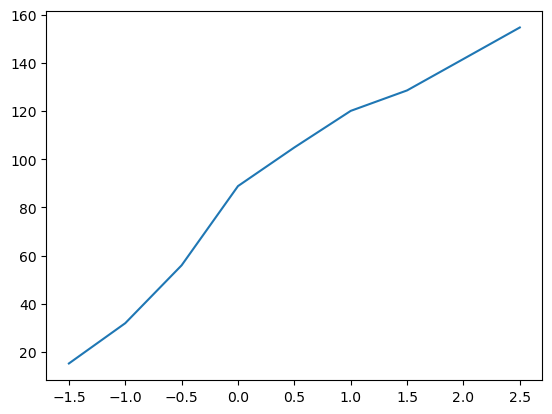

In [72]:
import matplotlib.pyplot as plt
e_facs = [x/2 for x in range(-3, 6)]
plt.plot(e_facs, [x for x in sq_wavs])
plt.show()

In [80]:
base_wav_trim, idx = librosa.effects.trim(
                y=wavs[3].cpu().numpy(),
                top_db=60,
                frame_length=1024,
                hop_length=256,
            )

In [125]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
for p, wav in zip(p_, wavs):
    plus_e = f'+{e}' if e > 0 else e
    half_e = f'+{e/2}' if e > 0 else e/2
    sf.write(save_dir / f'that.th{half_e}a{plus_e}.wav', wav.cpu().numpy(), 22050, "PCM_16")

In [96]:
ef = e_factor.squeeze().cpu().numpy().tolist()

In [100]:
durations = output_dict['duration'].squeeze().cpu().numpy().tolist()

In [128]:
hop_length = 256
base_wav = wavs[3].cpu().numpy()
mod_wav = wavs[-1].cpu().numpy()
start_pos = 0
end_pos = 0
new_wav = []
for d, e in zip(durations, ef):
    end_pos += d*hop_length
    base_segment = base_wav[start_pos:end_pos]
    mod_segment = mod_wav[start_pos:end_pos]
    amplitude_factor = math.sqrt(2 / (1 + math.exp(-e)))
    new_wav.append(base_segment * amplitude_factor)
    start_pos = end_pos
new_wav = np.concatenate(new_wav)

In [121]:
for d, e in zip(durations, ef):
    print(2 / (1 + math.exp(-e)))

1.5545997223493822
1.848283639957513
1.5545997223493822
1.0


In [129]:
sf.write(save_dir / f"that._sigm_dsp.wav", new_wav, 22050, "PCM_16")

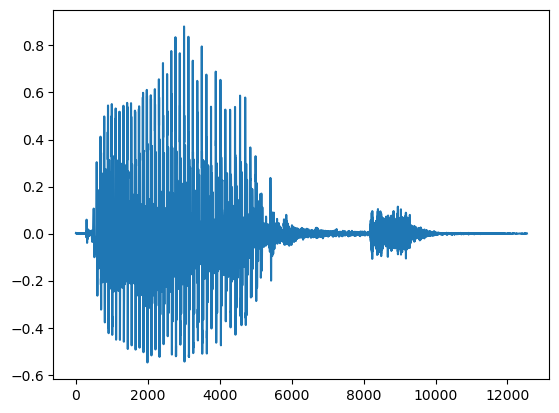

In [122]:
plt.plot(new_wav)

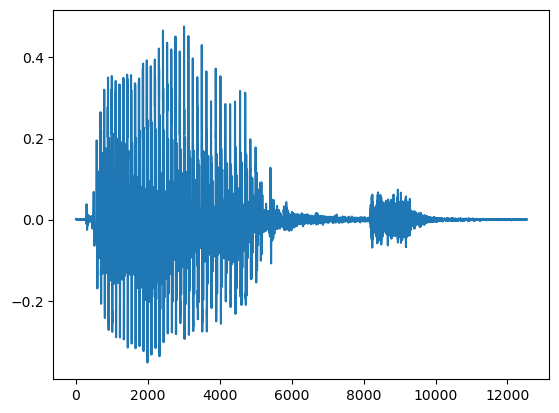

In [123]:
plt.plot(base_wav)

In [38]:
durations = output_dict['duration'].unsqueeze(0)
durations_lengths = torch.tensor(durations.size())

In [36]:
feats_lengths = torch.tensor([35], device=device)

In [43]:
base_energy, _ = pretrained_model.energy_extract(base_wav.unsqueeze(0), torch.tensor(base_wav.size()),
                                feats_lengths, durations, durations_lengths)

In [220]:
pitches = []
for wav in wavs:
    pitch, _ = pretrained_model.pitch_extract(wav.unsqueeze(0), torch.tensor(wav.size()),
                                feats_lengths, durations, durations_lengths)
    pitches.append(pitch.squeeze().mean().cpu().item())

In [234]:
new_pitches = []
for wav in new_wavs:
    pitch, _ = pretrained_model.pitch_extract(torch.tensor([wav]), torch.tensor([len(wav)]),
                                feats_lengths, durations, durations_lengths)
    new_pitches.append(pitch.squeeze().mean().cpu().item())

In [232]:

for wav, new_wav, i in zip(wavs, new_wavs, range(-4, 5)):
    shift = i*1.0
    # sf.write(save_dir / f"that.p{shift}.wav", wav.cpu().numpy(), 22050, "PCM_16")
    sf.write(save_dir / f"that.p{shift}_dsp.wav", new_wav, 22050, "PCM_16")

In [235]:
new_pitches

[4.923503398895264,
 5.0435590744018555,
 5.04128360748291,
 5.145663261413574,
 5.327414035797119,
 5.174620628356934,
 5.219992637634277,
 5.334314823150635,
 5.440422058105469]

In [236]:
pitches

[4.816781997680664,
 4.753146171569824,
 4.895610809326172,
 5.0483078956604,
 5.327413082122803,
 5.214310169219971,
 5.396207809448242,
 5.477133750915527,
 5.660858154296875]

In [202]:
base_wav = wavs[4].cpu().numpy()
start_pos = 0
end_pos = 0
positions = []
for d in durations:
    end_pos = start_pos + d * 256
    positions.append((start_pos, end_pos))
    start_pos = end_pos
segments = []
new_wavs = []
for p_factor in p_factorss:
    p_factor = p_factor.squeeze().cpu().numpy()
    for p, (start_pos, end_pos) in zip(p_factor, positions):
        segment = base_wav[start_pos:end_pos]
        segments.append(librosa.effects.pitch_shift(segment, sr=22050, n_steps=p))
    new_wavs.append(np.concatenate(segments))

In [56]:
import math
for i, wav in enumerate(wavs):
    print(torch.sum(wav*wav) / math.sqrt((i+2)/2-1))

tensor(88.8208, device='cuda:0')
tensor(85.6178, device='cuda:0')
tensor(84.8873, device='cuda:0')
tensor(81.2981, device='cuda:0')
tensor(81.7510, device='cuda:0')


In [50]:
print(torch.sum(base_energy))
for energy in energies:
    print(torch.sum(energy))

tensor(1026.3350, device='cuda:0')
tensor(1183.9402, device='cuda:0')
tensor(1293.1489, device='cuda:0')
tensor(1375.7120, device='cuda:0')
tensor(1475.3696, device='cuda:0')


In [40]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
os.makedirs(save_dir, exist_ok=True)
sf.write(save_dir / f"{orig_text}_dsp.wav", wav_result, 22050, "PCM_16")

tensor([[[ 0.5454],
         [ 5.4649],
         [32.8088],
         [63.3920],
         [78.6348],
         [82.7436],
         [84.2931],
         [86.2685],
         [85.7019],
         [82.4692],
         [78.6783],
         [72.1199],
         [63.8343],
         [53.3254],
         [39.5262],
         [26.0968],
         [12.8273],
         [ 6.6415],
         [ 7.2623],
         [ 6.4622],
         [12.5029],
         [14.8022],
         [ 8.7500],
         [ 5.0235],
         [ 3.1658],
         [ 2.8651],
         [ 2.3932],
         [ 1.5994],
         [ 1.2492],
         [ 1.1724],
         [ 1.0174],
         [ 0.8575],
         [ 0.7179],
         [ 0.6042],
         [ 0.5180]]], device='cuda:0')

In [44]:
wav_result[start_pos:]

array([-0.04571102, -0.0352678 , -0.01489699, ...,  0.00032871,
        0.00042657,  0.00053737], dtype=float32)

In [26]:
import numpy as np
num_points = len(wav_edit)
x = np.linspace(0, num_points, num=num_points*4)
interpolated = np.interp(x, list(range(0, num_points)), wav_edit)

In [30]:
wav_result = np.concatenate([start_wav, interpolated, end_wav])

In [47]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
os.makedirs(save_dir, exist_ok=True)
sf.write(save_dir / f"{orig_text}_dsp.wav", wav_result, 22050, "PCM_16")

In [13]:
' '.join(phonemes)

'DH IH1 S IH1 Z AH0 V EH1 R IY0 L AO1 NG T EH1 K S T , W IH1 CH AY1 IH0 K S P EH1 K T DH AH0 M AA1 D AH0 L T UW1 R EH1 D P R AA1 P ER0 L IY0 AH0 N D N AA1 T T UW1 F AE1 S T .'

In [28]:
with torch.no_grad():
    outputs = []
    for phone_ids, d_factor in zip(batch_phone_ids, batch_d_factor):
        output_dict = pretrained_model.tts.inference(text=phone_ids, d_factor=d_factor)
        outputs.append(output_dict)

Duration pred: tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration (new): tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration pred: tensor([[ 7,  6, 12,  7,  6,  8,  6,  6,  7,  9,  7,  9,  9,  9, 10,  9,  7,  7,
          5,  5,  7, 11,  9,  9,  7,  8,  6,  6,  6,  4,  5,  6,  7,  9,  6,  7,
         15,  7,  7,  8,  9,  7,  6,  7,  7,  7,  8,  8,  7,  6,  7,  7,  6,  8,
          7,  7, 11, 10, 17, 16,  7,  9]], device='cuda:0')
Duration (new): tensor([[ 7, 24, 12,  7,  6, 

In [39]:
#                             IH1 Z DH AE1 T K ER0 EH1 K T ?

In [ ]:
p_factor = [float(x) for x in '0  0  0  0  0 0 -0.8 0.8 1 1 0'.split()]
p_factor = torch.FloatTensor(p_factor).to(device)

In [109]:
save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / pretrained_dir.stem
os.makedirs(save_dir, exist_ok=True)

for output_dict, text in zip(outputs, batch_text):
    # save as PCM 16 bit wav file
    sf.write(
        save_dir / f"{text}.wav",
        output_dict['wav'].detach().cpu().numpy(),
        22050,
        "PCM_16",
    )

In [105]:
batch_text

['THIS, *is* ^AB^soLUTE_ly craaaaazzzyyyyy!!']

In [56]:
def get_vocoder(checkpoint):
    vocoder = load_vocoder(checkpoint)
    # logging.info(f"Loaded model parameters from {checkpoint}.")
    vocoder.remove_weight_norm()
    vocoder = vocoder.eval().to(device)
    return vocoder

In [57]:
pwgan = get_vocoder(LJSPEECH_DIR / 'parallel_wavegan' / 'checkpoint-3000000steps.pkl')

In [7]:
hifigan = get_vocoder(VCTK_DIR / 'hifigan' / 'checkpoint-2500000steps.pkl')

In [58]:
def save_wav(model, model_file, vocoder, filename, text, duration_scaling=None, pitch_scaling=None, energy_scaling=None):
    with torch.no_grad():
        output_dic = model.tts.inference(
            text=text, duration_scaling=duration_scaling, pitch_scaling=pitch_scaling, energy_scaling=energy_scaling)
    mel = output_dic['feat_gen']
    y = vocoder.inference(mel, normalize_before=False).view(-1)
    save_dir = Path('/home/perry/PycharmProjects/prosody/prosody') / model_file.parent.stem / model_file.stem
    os.makedirs(save_dir, exist_ok=True)
    # save as PCM 16 bit wav file
    sf.write(
        save_dir / f"{filename}.wav",
        y.detach().cpu().numpy(),
        22050,
        "PCM_16",
    )

In [59]:
from montreal_forced_aligner.g2p.generator import PyniniValidator
from montreal_forced_aligner.models import G2PModel #, ModelManager
language = "english_us_mfa"
# manager = ModelManager()
# manager.download_model("g2p", language)
model_path = G2PModel.get_pretrained_path(language)
g2p = PyniniValidator(g2p_model_path=model_path, num_pronunciations=1, quiet=True)
words, mark_positions = preprocess(orig_text)
g2p.word_list = words
phonemes = g2p.generate_pronunciations()
phonemes = [p for word in g2p.word_list for p in phonemes.get(word, word)[0].split()]

DEBUG:validation_g2p:Beginning run for g2p on validation
DEBUG:validation_g2p:Using multiprocessing with 3
DEBUG:validation_g2p:Set up logger for MFA version: 2.0.5
INFO:validation_g2p:Generating pronunciations...
DEBUG:validation_g2p:Skipping 1 words for containing the following graphemes: !, *, ,, A, B, E, H, I, L, S, T, U, ^, and _
DEBUG:validation_g2p:Processed 4 in 0.8278882503509521 seconds


In [88]:
_, phone_ids, d_factor, p_factor, e_factor = get_inputs(orig_text, has_eos_token=True)
my_phone_ids = torch.tensor(my_id_conv.tokens2ids(phonemes), dtype=torch.int32, device=device)

In [82]:
len(phone_ids)

22

In [30]:
phonemes =                   'ʃ ɒː , d̪ ow z t w ɛ ɫ v b ej ʒ h ʊ k s ɛ ɹ dʒ ɔj n d ɪ f aj pʰ æ tʃ ə j ɐ ŋ , ɡ ʉː i m aw θ .'.split()
my_phone_ids = torch.tensor(my_id_conv.tokens2ids(phonemes), dtype=torch.int32, device=device)

In [48]:
phonemes =                   'ç ɪ z ɪ z ə v ə ɹ i l ɒ ŋ tʰ ɛ k s t , w ɪ tʃ aj ɪ k s p ɛ k t ð m ɑː d ɫ̩ tʰ ow ɹ iː d p ɹ ɑ p ɚ ʎ i æ n d n ɑ t tʰ ʉː f æ s t .'.split()
my_phone_ids = torch.tensor(my_id_conv.tokens2ids(phonemes), dtype=torch.int32, device=device)

In [77]:
d_factor = torch.tensor([[1.0]*(len(phonemes)+1)], device=device)

In [19]:
' '.join(my_id_conv.token_list)

'<blank> <unk> ə ɪ n s ɹ t d ð ɛ z æ w m sil v ɚ ej iː f i , k ɐ ɑ aj p b ɒ l ow tʲ ʔ tʰ ɫ . ʎ ʉː h ʃ ŋ pʰ ɲ kʰ dʲ ɫ̩ ɝ ç tʃ dʒ bʲ aw θ c cʰ mʲ ʉ ɟ ʊ ɡ n̩ fʲ ɒː vʲ j pʲ ɑː ɾ ɱ ɔj m̩ ʒ ɾʲ ? " ! t̪ d̪ \' <sos/eos>'

In [40]:
vowels = set('ə ɪ ɛ æ ɚ ej iː i ɐ ɑ aj ɒ ow ʉː ɝ aw ʉ ʊ ɒː ɑː ɔj'.split())

In [50]:
vowel_count = sum(phoneme in vowels for phoneme in phonemes)
batch_phone_ids = [my_phone_ids] * (1+vowel_count)
batch_d_factor = d_factor.repeat(1+vowel_count, 1)
batch_text = [orig_text] * (1+vowel_count)
count = 1
for i, phoneme in enumerate(phonemes):
    if phoneme in vowels:
        batch_text[count] = batch_text[count] + f'{count}{phoneme}x4'
        batch_d_factor[count][i] = 4.0
        count += 1

In [96]:
words

['this', ',', 'is', 'absolutely', 'crazy', '!', '!']

In [92]:
d_factor.size()

torch.Size([1, 23])

In [94]:
d_factor = d_factor.squeeze(0)

In [99]:
p_factor = p_factor.squeeze(0)
e_factor = e_factor.squeeze(0)

In [101]:
e_factor

tensor([1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.], device='cuda:0')

In [100]:
save_wav(my_fs2, my_model_file, pwgan, filename=orig_text, text=my_phone_ids,
         duration_scaling=d_factor, pitch_scaling=p_factor, energy_scaling=e_factor)

Duration pred: tensor([[ 3, 14, 25, 25, 11,  7, 19,  5, 11,  4,  9,  8,  5,  7,  4, 15,  4, 12,
          8, 18,  8,  7,  0]], device='cuda:0')
Duration (new): tensor([[ 3, 14, 25, 25, 11,  7, 19,  5, 11,  4,  9,  8,  5,  7,  4, 15,  4, 36,
         16, 54,  8,  7,  0]], device='cuda:0')
Pitch pred: tensor([[[ 2.6370e-01],
         [ 2.8156e-01],
         [ 7.8544e-02],
         [-3.6989e-02],
         [ 1.0073e-01],
         [ 5.4575e-02],
         [ 2.5324e-01],
         [ 3.5622e-01],
         [ 3.4414e-01],
         [ 3.2794e-01],
         [ 1.5558e-01],
         [ 6.1514e-02],
         [ 1.0552e-02],
         [ 3.5569e-03],
         [-2.3573e-02],
         [ 4.2233e-02],
         [ 1.3296e-01],
         [-6.7708e-02],
         [-2.0825e-01],
         [-2.0293e-01],
         [-2.0532e-01],
         [-2.1556e-01],
         [-7.7539e+00]]], device='cuda:0')
Pitch (new): tensor([[[ 0.2637],
         [ 0.2816],
         [ 0.0785],
         [-0.0370],
         [ 0.1007],
         [ 0.05

In [51]:
for my_phone_ids, text, d_factor in zip(batch_phone_ids, batch_text, batch_d_factor):
    save_wav(my_fs2, my_model_file, pwgan, filename=text, text=my_phone_ids,
             duration_scaling=d_factor, pitch_scaling=p_factor, energy_scaling=e_factor)

Duration pred: tensor([[ 3,  4,  6,  8,  6,  6,  6,  4,  6,  6,  9, 14, 10,  9, 13, 11,  8, 13,
         25,  5,  4,  9, 12,  9,  6,  8,  6,  7,  8,  3,  3, 10, 12,  3,  9, 15,
         13, 11, 14,  9,  8,  4,  7,  8,  7,  9, 11,  8,  6,  7,  5, 12,  9, 10,
          4, 12, 25, 19, 11,  6,  0]], device='cuda:0')
Duration (new): tensor([[ 3,  4,  6,  8,  6,  6,  6,  4,  6,  6,  9, 14, 10,  9, 13, 11,  8, 13,
         25,  5,  4,  9, 12,  9,  6,  8,  6,  7,  8,  3,  3, 10, 12,  3,  9, 15,
         13, 11, 14,  9,  8,  4,  7,  8,  7,  9, 11,  8,  6,  7,  5, 12,  9, 10,
          4, 12, 25, 19, 11,  6,  0]], device='cuda:0')
Duration pred: tensor([[ 3,  4,  6,  8,  6,  6,  6,  4,  6,  6,  9, 14, 10,  9, 13, 11,  8, 13,
         25,  5,  4,  9, 12,  9,  6,  8,  6,  7,  8,  3,  3, 10, 12,  3,  9, 15,
         13, 11, 14,  9,  8,  4,  7,  8,  7,  9, 11,  8,  6,  7,  5, 12,  9, 10,
          4, 12, 25, 19, 11,  6,  0]], device='cuda:0')
Duration (new): tensor([[ 3, 16,  6,  8,  6,  6,  6,  4, 

In [11]:
phonemes =                   ' '.join('ð ɪ s ɪ z ɡ ʊ d .'.split())
my_phone_ids = torch.IntTensor(my_id_conv.tokens2ids(phonemes)).to(device)

In [39]:
phonemes =                   ' '.join('ð iː kʰ ə mʲ ɪ ʃ ə n  ʃ  ɛ ɹ z ð ɪ s kʰ ə n s  ɝ  n .'.split())
my_phone_ids = torch.IntTensor(my_id_conv.tokens2ids(phonemes)).to(device)

In [40]:
duration_scaling = [float(x) for x in '1  1  1 1  1 1 1 1 1  1   1 1 1 1 1  1 1 1 1  1  1 1 1 1'.split()]
duration_scaling = np.array(duration_scaling)

In [12]:
pitch_scaling    = [float(x) for x in '0  0  0 0  0 0 0 0 0  0   0 0 0 0 0.5 0 0 0 0 0  0  0 0 0'.split()]
pitch_scaling    = np.array(pitch_scaling)

In [13]:
energy_scaling   = [float(x) for x in '1  1  1 1  1 1 1 1 1  1   1 1 1 1 5 1 1 1 1  1  1 1 1 1 1'.split()]
energy_scaling   = np.array(energy_scaling)

In [12]:
phonemes =                   ' '.join('ð ɪ s ɪ z ɡ ʊ d .'.split())
duration_scaling = [float(x) for x in '1 1 1 1 1 1 5 1 1  1'.split()]
duration_scaling = np.array(duration_scaling)

In [17]:
pitch_scaling    = [float(x) for x in '-1 0 1 0 0 0 0 0 0  0'.split()]
pitch_scaling    = np.array(pitch_scaling)

In [ ]:
energy_scaling   = [float(x) for x in '1 1 1 1 1 1 1 1 1  1'.split()]
energy_scaling   = np.array(energy_scaling)

In [14]:
arpa_phones =                         'DH AH0 K AH0 M IH1 SH AH0 N SH EH1 R Z DH IH1 S K AH0 N S AH0 R N .'.split()
phone_ids   = np.array(id_converter.tokens2ids(arpa_phones))

In [70]:
duration_scaling = [float(x) for x in '1   1  1  1  1  1   1  1  1  1  1  1 1  1  1  1 1  1  1 1  1  5 1 1 1'.split()]
duration_scaling = np.array(duration_scaling)

In [7]:
arpa_phones =                         'AA1 R Y UW1  SH UH1 R'.split(' ')
arpa_phones = [p if p else ' ' for p in arpa_phones]
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [24]:
duration_scaling = [float(x) for x in ' 1  4 1  1  1 1  1  4  1'.strip().split()]
duration_scaling = torch.FloatTensor(duration_scaling).to(device)

In [90]:
arpa_phones =                         'SH UH1 R'.split(' ')
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [31]:
duration_scaling = [float(x) for x in ' 1  4  4  1'.strip().split()]
duration_scaling = torch.FloatTensor(duration_scaling).to(device)

In [18]:
arpa_phones =                         'B UH1 K'.split(' ')
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [65]:
phone_ids

tensor([ 1, 53, 34, 68], device='cuda:0', dtype=torch.int32)

In [71]:
duration_scaling = [float(x) for x in '0.5 1  4  1  1'.strip().split()]
duration_scaling = torch.FloatTensor(duration_scaling).to(device)

In [19]:
phonemes =                            'b ʉː k'.split(' ')
my_phone_ids = torch.IntTensor(my_id_conv.tokens2ids(phonemes)).to(device)

In [21]:
duration_scaling = [float(x) for x in '1  4 1 1'.strip().split()]
duration_scaling = torch.FloatTensor(duration_scaling).to(device)

In [15]:
my_id_conv.ids2tokens(my_phone_ids)

['ð',
 'ɪ',
 's',
 'ɪ',
 'z',
 'ə',
 'c',
 'ɹ',
 'i',
 'ej',
 'tʲ',
 'ɪ',
 'v',
 's',
 'ə',
 'ʎ',
 'ʉː',
 'ʃ',
 'n̩',
 '.']

In [92]:
phonemes =                            'ʃ ʊ ɹ'.split(' ')
my_phone_ids = torch.IntTensor(my_id_conv.tokens2ids(phonemes)).to(device)

In [58]:
arpa_phones =                         'DH AH0 K AH0 M IH1 SH AH0 N SH EH1 R Z AH0 B UH1 UH1 UH1 UH1 K .'.split(' ')
phone_ids = torch.IntTensor(id_converter.tokens2ids(arpa_phones)).to(device)

In [55]:
duration_scaling = [float(x) for x in '1   1  1  1  1  1   1  1  1  1  1  1 1  1  1    1 1  1'.split()]
duration_scaling = torch.FloatTensor(duration_scaling).to(device)

In [67]:
pretrained_fs2.preprocess_fn("<dummy>", dict(text='book'))["text"]

array([53, 34, 68])

In [22]:
save_wav(model=my_fs2, model_file=my_model_file, vocoder=pwgan,
         filename='this_is_a_creative_solution', text=my_phone_ids)

fastspeech2_0


In [23]:
save_wav(model=my_fs2, model_file=my_model_file, vocoder=pwgan,
         filename='boooook', text=my_phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[ 5, 16, 12,  0]], device='cuda:0')
Duration (new): tensor([[ 5, 64, 12,  0]], device='cuda:0')


In [95]:
save_wav(model=my_fs2, vocoder=pwgan, filename='suuuure', text=my_phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[16, 19, 14,  0]], device='cuda:0')
Duration (new): tensor([[16, 76, 14,  0]], device='cuda:0')


In [89]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='book', text=phone_ids)

In [73]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='.boooook', text=phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[ 3,  8, 13,  9, 15]], device='cuda:0')
Duration (new): tensor([[ 2,  8, 52,  9, 15]], device='cuda:0')


In [59]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='thecommissionsharesabo;;ok', text=phone_ids)

In [38]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='areyousure(q)', text=phone_ids)

In [91]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='sure', text=phone_ids)

In [50]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='_boooook', text=phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[ 5, 10, 14,  9, 16]], device='cuda:0')
Duration (new): tensor([[ 5, 10, 56,  9, 16]], device='cuda:0')


In [32]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='suuurrrre', text=phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[ 7, 14, 15, 19]], device='cuda:0')
Duration (new): tensor([[ 7, 56, 60, 19]], device='cuda:0')


In [25]:
save_wav(model=pretrained_fs2, vocoder=pwgan, filename='arrreyou_surrrre', text=phone_ids, duration_scaling=duration_scaling)

Duration pred: tensor([[ 3,  8,  8,  8,  8, 11, 12, 13, 17]], device='cuda:0')
Duration (new): tensor([[ 3, 32,  8,  8,  8, 11, 12, 52, 17]], device='cuda:0')


In [51]:
save_wav(pretrained_fs2, 'LJ050-0075_concerrrrrn', text=phone_ids, duration_scaling=duration_scaling)

[69 76 68 76 64 66 43 76 75 43 63 71 67 69 66 72 68 76 75 72 76 71 75 45]


tensor([[-1.3969, -0.8583, -0.8896,  ...,  0.6136,  0.5762,  0.6000],
        [-0.5911, -0.1105,  0.2743,  ...,  0.5918,  0.5819,  0.6414],
        [-0.1450,  0.1302,  0.7574,  ...,  0.4194,  0.5463,  0.7029],
        ...,
        [-1.3131, -0.9279, -1.3022,  ..., -1.1957, -1.2971, -1.3577],
        [-1.3000, -0.9907, -1.3771,  ..., -1.2181, -1.3120, -1.3717],
        [-1.3402, -1.0958, -1.4299,  ..., -1.2188, -1.3229, -1.3871]],
       device='cuda:0')